In [160]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from copulae1 import *
from KDEs import *
from toolbox import *

In [161]:
dataPath = '/Volumes/external_SSD/copulaData/Deribit_raw/'
futures = pd.read_csv(dataPath+'deribit_futures.csv')
ETH = pd.read_csv(dataPath+'ETH_index_Deribit_hourly.csv')
BTC = pd.read_csv(dataPath+'BTC_index_Deribit_hourly.csv')

In [162]:
ETH.datetime = pd.to_datetime(ETH.datetime)
BTC.datetime = pd.to_datetime(BTC.datetime)

In [163]:
def getExpirationTime(instrument_name):
    try:
        text = instrument_name[instrument_name.find('-')+1:]
        return pd.to_datetime(text) + datetime.timedelta(hours=8)
    except:
        return 0

In [164]:
futures.loc[:, 'datetime'] = pd.to_datetime(futures.timestamp)
futures = futures.sort_values('datetime').reset_index(drop=True)

In [165]:
def roundToHour(datetime):
    return datetime.replace(second=0, microsecond=0, minute=0)

In [166]:
# futures = futures.drop_duplicates(['datetimeHour', 'instrument_name'], keep='first')

# last price to open price
futures.loc[:, 'datetimeShifted'] = futures.datetime + datetime.timedelta(hours=1)
futures.loc[:, 'datetimeHour'] = futures.datetimeShifted.apply(roundToHour)
futures.rename(columns = {'last':'open'}, inplace=True)
futures = futures.drop_duplicates(['datetimeHour', 'instrument_name'], keep='last')

In [167]:
futures.loc[:,'expiryDateTime'] = futures.instrument_name.apply(getExpirationTime)

In [168]:
futures = futures.loc[futures.loc[:,'expiryDateTime'] != 0, :]

In [169]:
futures.expiryDateTime = pd.to_datetime(futures.expiryDateTime)

In [170]:
futures.datetimeHour = futures.datetimeHour.apply(lambda x: x.replace(tzinfo=None))

In [171]:
futures.loc[:, 'timeToMaturity'] = futures.expiryDateTime - futures.datetimeHour 
futures.loc[:, 'timeToMaturityinYears'] = futures.timeToMaturity.apply(lambda x:x.total_seconds()/365/24/60/60)


In [172]:
_id = futures.base_currency == 'ETH'
_id &= futures.quote_currency == 'USD'
ETH_futures = futures.loc[_id,:]

_id = futures.base_currency == 'BTC'
_id &= futures.quote_currency == 'USD'
BTC_futures = futures.loc[_id,:]

In [173]:
BTC_futures = BTC_futures.sort_values(['datetimeHour', 'timeToMaturityinYears'])

In [174]:
datetimeHour_arr = list(set(BTC_futures.datetimeHour))

In [175]:
_id = BTC_futures.datetimeHour==datetimeHour_arr[0]

BTC_futures.loc[_id,:]

,Unnamed: 0,timestamp,instrument_name,sectype,base_currency,quote_currency,expiry,strike,pcflag,mid_price,...,underlying_price,interest_rate,creation_timestamp,volume_notional,datetime,datetimeShifted,datetimeHour,expiryDateTime,timeToMaturity,timeToMaturityinYears
213608,2248589,2020-05-12 12:56:40.516000+00:00,BTC-26JUN20,FUT,BTC,USD,2020-06-26,NaN,NaN,8762.75,...,NaN,NaN,1589288200516,NaN,2020-05-12 12:56:40.516000+00:00,2020-05-12 13:56:40.516000+00:00,2020-05-12 13:00:00,2020-06-26 08:00:00,44 days 19:00:00,0.122717
213606,2248587,2020-05-12 12:56:40.516000+00:00,BTC-25SEP20,FUT,BTC,USD,2020-09-25,NaN,NaN,8825.50,...,NaN,NaN,1589288200516,NaN,2020-05-12 12:56:40.516000+00:00,2020-05-12 13:56:40.516000+00:00,2020-05-12 13:00:00,2020-09-25 08:00:00,135 days 19:00:00,0.372032
213607,2248588,2020-05-12 12:56:40.516000+00:00,BTC-25DEC20,FUT,BTC,USD,2020-12-25,NaN,NaN,8899.75,...,NaN,NaN,1589288200516,NaN,2020-05-12 12:56:40.516000+00:00,2020-05-12 13:56:40.516000+00:00,2020-05-12 13:00:00,2020-12-25 08:00:00,226 days 19:00:00,0.621347


In [176]:
BTCUSD_BTCUSD = pd.merge(BTC_futures, BTC,
                         left_on='datetimeHour', right_on='datetime') 
BTCUSD_BTCUSD = BTCUSD_BTCUSD.loc[:, ['datetimeHour','timeToMaturityinYears', 'datetime_y', 'mid_price', 'index_price']]
BTC_datetimeHour_arr = list(set(BTCUSD_BTCUSD.datetimeHour))


ETHUSD_BTCUSD = pd.merge(BTC_futures, ETH,
                         left_on='datetimeHour', right_on='datetime') 
ETHUSD_BTCUSD = ETHUSD_BTCUSD.loc[:, ['datetimeHour','timeToMaturityinYears', 'datetime_y', 'mid_price', 'index_price']]
ETH_datetimeHour_arr = list(set(ETHUSD_BTCUSD.datetimeHour))

In [177]:
BTCUSD_BTCUSD = BTCUSD_BTCUSD.sort_values(['timeToMaturityinYears']).reset_index(drop=True)
ETHUSD_BTCUSD = ETHUSD_BTCUSD.sort_values(['timeToMaturityinYears']).reset_index(drop=True)

In [178]:
rows = []
for i in range(len(BTC_datetimeHour_arr)):
    _id = BTCUSD_BTCUSD.datetimeHour == BTC_datetimeHour_arr[i]
    rows.append(BTCUSD_BTCUSD.loc[_id,].iloc[0:1,:])
BTCUSD_BTCUSD = pd.concat(rows).sort_values('datetimeHour').reset_index(drop=True)

In [179]:
rows = []
for i in range(len(ETH_datetimeHour_arr)):
    _id = ETHUSD_BTCUSD.datetimeHour == ETH_datetimeHour_arr[i]
    rows.append(ETHUSD_BTCUSD.loc[_id,].iloc[0:1,:])
ETHUSD_BTCUSD = pd.concat(rows).sort_values('datetimeHour').reset_index(drop=True)

In [180]:
intervals = list(range(1,(24*14)+1))

BTC_samples = dict()
ETH_samples = dict()

for interval in intervals:
    BTC_samples[interval] = BTCUSD_BTCUSD.iloc[::interval,:]
    ETH_samples[interval] = ETHUSD_BTCUSD.iloc[::interval,:]

In [181]:
BTC_rho_results = dict()
C1 = Gaussian(dict(rho=0.9), Law_RS=stats.norm, Law_RF=stats.norm) 
C2 = t_Copula(dict(rho=0.9, nu=4), Law_RS=stats.norm, Law_RF=stats.norm, nu_lowerbound=2)

for interval in intervals:
    BTC_df = BTC_samples[interval]

    BTC_rs = np.log(BTC_df.index_price/BTC_df.index_price.shift(1))[1:]
    BTC_rf = np.log(BTC_df.mid_price/BTC_df.mid_price.shift(1))[1:]
    BTC_rs = np.array(BTC_rs)
    BTC_rf = np.array(BTC_rf)
    
    u = ECDF(BTC_rs)(BTC_rs)
    v = ECDF(BTC_rf)(BTC_rf)

    kde_brr = KDE(BTC_rs, "Gaussian")
    kde_btc = KDE(BTC_rf, "Gaussian")
    
#     C1.Law_RS = kde_brr
#     C1.Law_RF = kde_btc
#     BTC_rho = C1.canonical_calibrate(u, v)

    C2.Law_RS = kde_brr
    C2.Law_RF = kde_btc
    BTC_rho = C2.canonical_calibrate(u, v)
    BTC_rho_results[interval] = BTC_rho

Optimization terminated successfully.
         Current function value: -29114.138412
         Iterations: 115
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -17828.109925
         Iterations: 138
         Function evaluations: 259
Optimization terminated successfully.
         Current function value: -13069.885240
         Iterations: 128
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: -10303.961286
         Iterations: 81
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -8508.433959
         Iterations: 138
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: -7295.905433
         Iterations: 109
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -6419.439587
         Iterations: 101
         Function evalua

Optimization terminated successfully.
         Current function value: -970.267939
         Iterations: 69
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -984.939586
         Iterations: 126
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: -946.319583
         Iterations: 134
         Function evaluations: 244
Optimization terminated successfully.
         Current function value: -938.226378
         Iterations: 108
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: -871.708538
         Iterations: 115
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: -912.958713
         Iterations: 104
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: -865.577776
         Iterations: 77
         Function evaluations: 166
O

Optimization terminated successfully.
         Current function value: -496.200651
         Iterations: 139
         Function evaluations: 273
Optimization terminated successfully.
         Current function value: -498.588962
         Iterations: 99
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -480.445277
         Iterations: 98
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -515.405280
         Iterations: 116
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: -475.932251
         Iterations: 85
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -474.336793
         Iterations: 113
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -458.910013
         Iterations: 139
         Function evaluations: 276
Op

Optimization terminated successfully.
         Current function value: -322.003711
         Iterations: 120
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -335.126640
         Iterations: 110
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -311.611337
         Iterations: 73
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -322.492659
         Iterations: 187
         Function evaluations: 360
Optimization terminated successfully.
         Current function value: -283.014111
         Iterations: 122
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -332.416821
         Iterations: 123
         Function evaluations: 235
Optimization terminated successfully.
         Current function value: -317.309893
         Iterations: 96
         Function evaluations: 185
O

Optimization terminated successfully.
         Current function value: -279.954888
         Iterations: 94
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -264.451858
         Iterations: 95
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -267.907947
         Iterations: 96
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -244.216060
         Iterations: 133
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -257.946793
         Iterations: 124
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -251.114134
         Iterations: 112
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -257.431931
         Iterations: 140
         Function evaluations: 260
Op

Optimization terminated successfully.
         Current function value: -183.458083
         Iterations: 122
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: -238.693118
         Iterations: 120
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -195.794036
         Iterations: 79
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -168.500461
         Iterations: 134
         Function evaluations: 257
Optimization terminated successfully.
         Current function value: -205.453004
         Iterations: 101
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: -212.056580
         Iterations: 111
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -197.845540
         Iterations: 123
         Function evaluations: 232


In [182]:
ETH_rho_results = dict()
C1 = Gaussian(dict(rho=0.9), Law_RS=stats.norm, Law_RF=stats.norm) 
C2 = t_Copula(dict(rho=0.1, nu=4), Law_RS=stats.norm, Law_RF=stats.norm, nu_lowerbound=2)

for interval in intervals:
    ETH_df = ETH_samples[interval]
    ETH_rs = np.log(ETH_df.index_price/ETH_df.index_price.shift(1))[1:]
    ETH_rf = np.log(ETH_df.mid_price/ETH_df.mid_price.shift(1))[1:]
    ETH_rs = np.array(ETH_rs)
    ETH_rf = np.array(ETH_rf)
    
    u = ECDF(ETH_rs)(ETH_rs)
    v = ECDF(ETH_rf)(ETH_rf)
    
    kde_brr = KDE(ETH_rs, "Gaussian")
    kde_btc = KDE(ETH_rf, "Gaussian")
    
#     C1.Law_RS = kde_brr
#     C1.Law_RF = kde_btc
    
#     ETH_rho = C1.canonical_calibrate(u, v)
    
    C2.Law_RS = kde_brr
    C2.Law_RF = kde_btc
    ETH_rho = C2.canonical_calibrate(u, v)
    
    ETH_rho_results[interval] = ETH_rho

Optimization terminated successfully.
         Current function value: -13060.205702
         Iterations: 110
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: -7134.375867
         Iterations: 68
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -4894.137283
         Iterations: 68
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -3583.061128
         Iterations: 73
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -2892.193839
         Iterations: 64
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -2404.771277
         Iterations: 71
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -2045.136045
         Iterations: 72
         Function evaluations: 1

Optimization terminated successfully.
         Current function value: -193.188898
         Iterations: 76
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -204.328252
         Iterations: 74
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -205.923353
         Iterations: 78
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -187.566062
         Iterations: 71
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -183.704977
         Iterations: 75
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -206.998275
         Iterations: 86
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: -196.259776
         Iterations: 84
         Function evaluations: 176
Optimi

Optimization terminated successfully.
         Current function value: -84.391987
         Iterations: 82
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -106.383112
         Iterations: 71
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -94.662797
         Iterations: 72
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -95.070766
         Iterations: 81
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: -92.668452
         Iterations: 78
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -100.709293
         Iterations: 80
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -79.979086
         Iterations: 82
         Function evaluations: 169
Optimizatio

Optimization terminated successfully.
         Current function value: -68.377647
         Iterations: 69
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -59.215535
         Iterations: 70
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -58.330205
         Iterations: 101
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: -54.031407
         Iterations: 87
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -63.006979
         Iterations: 69
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -71.656260
         Iterations: 73
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -54.744038
         Iterations: 95
         Function evaluations: 209
Optimization

Optimization terminated successfully.
         Current function value: -43.398326
         Iterations: 83
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -44.960585
         Iterations: 78
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -45.432283
         Iterations: 78
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -50.074278
         Iterations: 70
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -44.218045
         Iterations: 73
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -45.646585
         Iterations: 137
         Function evaluations: 257
Optimization terminated successfully.
         Current function value: -40.559212
         Iterations: 77
         Function evaluations: 170
Optimization

/Users/francis/Google Drive/00_IRTG1792/copula/revision/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
/Users/francis/Google Drive/00_IRTG1792/copula/revision/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
/Users/francis/Google Drive/00_IRTG1792/copula/revision/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -31.512837
         Iterations: 140
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: -32.586508
         Iterations: 101
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -39.539823
         Iterations: 74
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -40.912849
         Iterations: 74
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -41.836517
         Iterations: 77
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -37.389030
         Iterations: 147
         Function evaluations: 282
Optimization terminated successfully.
         Current function value: -37.575313
         Iterations: 138
         Function evaluations: 261
Optimizat

Optimization terminated successfully.
         Current function value: -33.131798
         Iterations: 74
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -26.557764
         Iterations: 72
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -27.859780
         Iterations: 70
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -26.468393
         Iterations: 77
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -32.665268
         Iterations: 81
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: -33.332838
         Iterations: 80
         Function evaluations: 171


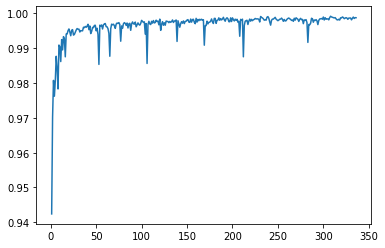

In [131]:
BTC_corr_results =  dict()
for interval in intervals:
    BTC_df = BTC_samples[interval]
    BTC_rs = np.log(BTC_df.index_price/BTC_df.index_price.shift(1))[1:]
    BTC_rf = np.log(BTC_df.mid_price/BTC_df.mid_price.shift(1))[1:]
    BTC_rs = np.array(BTC_rs)
    BTC_rf = np.array(BTC_rf)
    BTC_corr_results[interval] = np.corrcoef(BTC_rs, BTC_rf)[0][1]
    
plt.plot(pd.Series(BTC_corr_results))

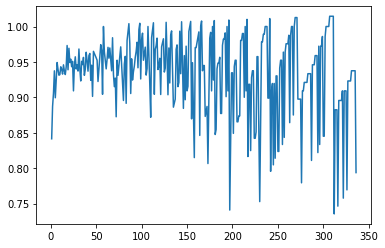

In [136]:
BTC_tailDependence_10_results =  dict()
for interval in intervals:
    BTC_df = BTC_samples[interval]
    BTC_rs = np.log(BTC_df.index_price/BTC_df.index_price.shift(1))[1:]
    BTC_rf = np.log(BTC_df.mid_price/BTC_df.mid_price.shift(1))[1:]
    BTC_rs = np.array(BTC_rs)
    BTC_rf = np.array(BTC_rf)
        
    u = ECDF(BTC_rs)(BTC_rs)
    v = ECDF(BTC_rf)(BTC_rf)
    
    BTC_tailDependence_10_results[interval] = empirical_lambda(u, v, .1)
    
plt.plot(pd.Series(BTC_tailDependence_10_results))


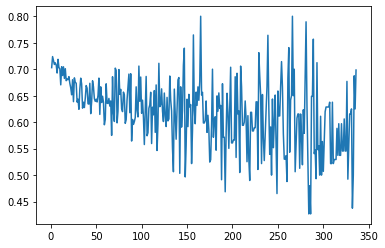

In [150]:
ETH_tailDependence_10_results =  dict()

for interval in intervals:
    ETH_df = ETH_samples[interval]
    ETH_rs = np.log(ETH_df.index_price/ETH_df.index_price.shift(1))[1:]
    ETH_rf = np.log(ETH_df.mid_price/ETH_df.mid_price.shift(1))[1:]
    ETH_rs = np.array(ETH_rs)
    ETH_rf = np.array(ETH_rf)
    
    u = ECDF(ETH_rs)(ETH_rs)
    v = ECDF(ETH_rf)(ETH_rf)
    
    ETH_tailDependence_10_results[interval] = empirical_lambda(u, v, .75)
    
plt.plot(pd.Series(ETH_tailDependence_10_results))

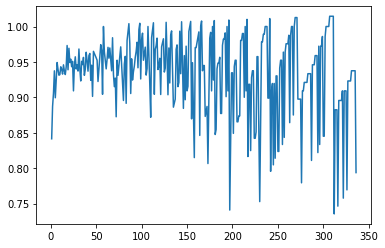

In [144]:
plt.plot(pd.Series(BTC_tailDependence_10_results)[:])

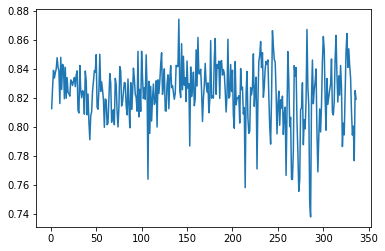

In [130]:
ETH_corr_results =  dict()
for interval in intervals:
    ETH_df = ETH_samples[interval]    
    ETH_rs = np.log(ETH_df.index_price/ETH_df.index_price.shift(1))[1:]
    ETH_rf = np.log(ETH_df.mid_price/ETH_df.mid_price.shift(1))[1:]
    ETH_rs = np.array(ETH_rs)
    ETH_rf = np.array(ETH_rf)
    ETH_corr_results[interval] = np.corrcoef(ETH_rs, ETH_rf)[0][1]
    
plt.plot(pd.Series(ETH_corr_results))

ValueError: setting an array element with a sequence.

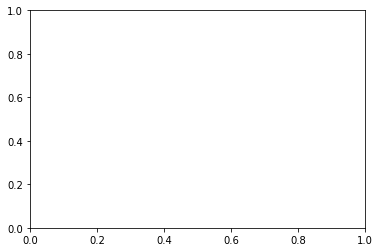

In [159]:
plt.plot(pd.Series(BTC_rho_results))
plt.plot(pd.Series(ETH_rho_results))

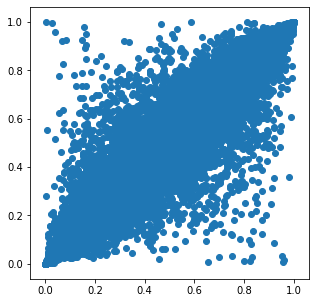

In [106]:
BTC_df = BTC_samples[1]
BTC_rs = np.log(BTC_df.index_price/BTC_df.index_price.shift(1))[1:]
BTC_rf = np.log(BTC_df.mid_price/BTC_df.mid_price.shift(1))[1:]
BTC_rs = np.array(BTC_rs)
BTC_rf = np.array(BTC_rf)

u = ECDF(BTC_rs)(BTC_rs)
v = ECDF(BTC_rf)(BTC_rf)

plt.figure(figsize=(5,5))
plt.scatter(u,v)

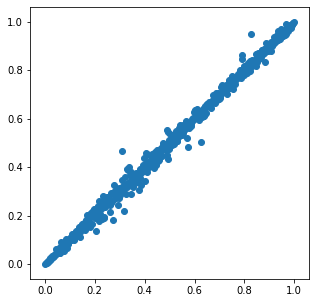

In [109]:
BTC_df = BTC_samples[47]
BTC_rs = np.log(BTC_df.index_price/BTC_df.index_price.shift(1))[1:]
BTC_rf = np.log(BTC_df.mid_price/BTC_df.mid_price.shift(1))[1:]
BTC_rs = np.array(BTC_rs)
BTC_rf = np.array(BTC_rf)

u = ECDF(BTC_rs)(BTC_rs)
v = ECDF(BTC_rf)(BTC_rf)

plt.figure(figsize=(5,5))
plt.scatter(u,v)

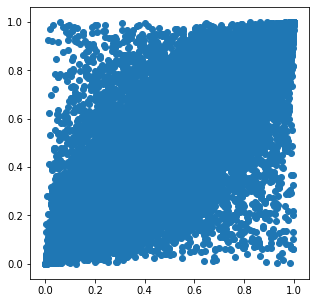

In [103]:
ETH_df = ETH_samples[1]
ETH_rs = np.log(ETH_df.index_price/ETH_df.index_price.shift(1))[1:]
ETH_rf = np.log(ETH_df.mid_price/ETH_df.mid_price.shift(1))[1:]
ETH_rs = np.array(ETH_rs)
ETH_rf = np.array(ETH_rf)

u = ECDF(ETH_rs)(ETH_rs)
v = ECDF(ETH_rf)(ETH_rf)

plt.figure(figsize=(5,5))
plt.scatter(u,v)

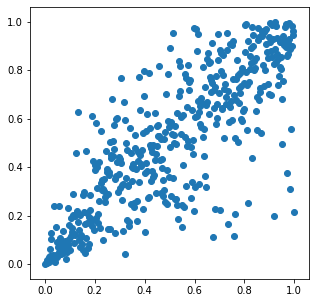

In [110]:
ETH_df = ETH_samples[47]
ETH_rs = np.log(ETH_df.index_price/ETH_df.index_price.shift(1))[1:]
ETH_rf = np.log(ETH_df.mid_price/ETH_df.mid_price.shift(1))[1:]
ETH_rs = np.array(ETH_rs)
ETH_rf = np.array(ETH_rf)

u = ECDF(ETH_rs)(ETH_rs)
v = ECDF(ETH_rf)(ETH_rf)

plt.figure(figsize=(5,5))
plt.scatter(u,v)